# Setup

In [1]:
import torch
import pandas as pd
import numpy as np
import datetime
import os.path as osp
from torch_geometric.explain import Explainer, CaptumExplainer,ModelConfig,GNNExplainer
from torch_geometric.nn import SAGEConv, GATConv
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
import matplotlib.pyplot as plt

# Utility

In [2]:
import copy

def initialize_features(data,feature,dim,inplace=False):
    if inplace:
        data_object = data
    else:
        data_object = copy.copy(data)
    for nodetype, store in data_object.node_items():
        if feature == "random":
            data_object[nodetype].x = torch.rand(store["num_nodes"],dim)
        if feature == "ones":
            data_object[nodetype].x = torch.ones(store["num_nodes"],dim)
    return data_object

# Load DBLP dataset

In [53]:
import torch_geometric.transforms as T
from torch_geometric.datasets import DBLP

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

path = "../../data/DBLP"
dataset = DBLP(path)
data = dataset[0]

p_val = 0.1
p_test = 0.1

edge_types = [('author', 'to', 'paper'),('paper', 'to', 'term'),('paper', 'to', 'conference')]
rev_edge_types = [('paper', 'to', 'author'),('term', 'to', 'paper'),('conference', 'to', 'paper')]

data["conference"].x = torch.eye(data["conference"].num_nodes)

data = T.ToUndirected()(data)
split_transform = T.RandomLinkSplit(num_val=p_val, num_test=p_test, is_undirected=True, add_negative_train_samples=True, disjoint_train_ratio=0.2,edge_types=edge_types,rev_edge_types=rev_edge_types)
transform_dataset = T.Compose([split_transform, T.ToSparseTensor(remove_edge_index=False)])

train_data, val_data, test_data = transform_dataset(data)

# Load gene_disease dataset

In [3]:
import copy

data_folder = "../../data/processed/graph_data_nohubs/"
models_folder = "../../data/models/"
experiments_folder = "../../data/experiments/design_space_experiment/"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# import sys
# sys.path.append("../..")
# from src.models.base_model import base_model

In [5]:
def load_data(folder_path,load_test = False,load_full=False):
    if load_test:
        names = ["train","validation","test"]
    else:
        names = ["train","validation"]
    datasets = []
    for name in names:
        path = folder_path+name+".pt"
        datasets.append(torch.load(path))
    
    return datasets

def initialize_features(data,feature,dim,inplace=False):
    if inplace:
        data_object = data
    else:
        data_object = copy.copy(data)
    for nodetype, store in data_object.node_items():
        if feature == "random":
            data_object[nodetype].x = torch.rand(store["num_nodes"],dim)
        if feature == "ones":
            data_object[nodetype].x = torch.ones(store["num_nodes"],dim)
    return data_object

# def load_model(state_dict,params,metadata):
#     model = base_model(params,metadata,supervision_types=[('gene_protein', 'gda', 'disease')])
#     model.load_state_dict(state_dict)
#     return model

def load_experiment(eid:int,date:str,metadata:tuple) -> tuple:
    """Returns tuple (model,params).
    date format: d_m_y"""
    df_path = f"{experiments_folder}experiment_{date}.parquet"
    weights_path = f"{experiments_folder}experiment_{eid}_{date}__.pth"

    df = pd.read_parquet(df_path)
    #TODO: this is only temporal, remove after fix
    df["conv_type"] = df.conv_type.apply(lambda x: x.split(".")[-1].rstrip("\'>"))
    df["activation"] = torch.nn.LeakyReLU
    params = df.loc[eid].to_dict()
    weights = torch.load(weights_path,map_location=torch.device(device))

    # model = base_model(params,metadata)
    # model.load_state_dict(weights)

    return params

def load_node_csv(path, index_col,type_col, **kwargs):
    """Returns node dataframe and a dict of mappings for each node type. 
    Each mapping maps from original df index to "heterodata index" { node_type : { dataframe_index : heterodata_index}}"""
    df = pd.read_csv(path, **kwargs,index_col=index_col)
    node_types = df[type_col].unique()
    mappings_dict = dict()
    for node_type in node_types:
        mapping = {index: i for i, index in enumerate(df[df[type_col] == node_type].index.unique())}
        mappings_dict[node_type] = mapping

    return df,mappings_dict

In [6]:
train_data,val_data = load_data(data_folder+"split_dataset/")
full_data = torch.load(data_folder+"split_dataset/full_dataset.pt")

eid = 34
date = "18_04_23"
experiment_params = load_experiment(eid,date,train_data.metadata())

train_data = initialize_features(train_data,experiment_params["feature_type"],experiment_params["feature_dim"])
val_data = initialize_features(train_data,experiment_params["feature_type"],experiment_params["feature_dim"])
full_data = initialize_features(full_data,experiment_params["feature_type"],experiment_params["feature_dim"])

# Base model

In [54]:
# import torch
# from torch_geometric.nn import SAGEConv,GATConv, to_hetero
# from torch_geometric.nn import HeteroDictLinear

# class inner_product_decoder(torch.nn.Module):
#     def forward(self,x_source,x_target,edge_index,apply_sigmoid=True):
#         nodes_src = x_source[edge_index[0]]
#         nodes_trg = x_target[edge_index[1]]
#         pred = (nodes_src * nodes_trg).sum(dim=-1)

#         if apply_sigmoid:
#             pred = torch.sigmoid(pred)

#         return pred

# class base_message_layer(torch.nn.Module):

#     def __init__(self, model_params,hidden_layer=True):
#         super().__init__()

#         # Currently SageConv or GATConv, might have to modify this to support other Convs
#         conv_type = model_params["conv_type"]
#         self.conv = layer_dict[conv_type]((-1,-1), model_params["hidden_channels"],aggr=model_params["micro_aggregation"],add_self_loops=False)
#         self.normalize = model_params["L2_norm"]

#         post_conv_modules = []
#         if model_params["batch_norm"]:
#             bn = torch.nn.BatchNorm1d(model_params["hidden_channels"])
#             post_conv_modules.append(bn)
        
#         if model_params["dropout"] > 0:    
#             dropout = torch.nn.Dropout(p=model_params["dropout"])
#             post_conv_modules.append(dropout)
        
#         # No activation on final embedding layer
#         if hidden_layer:
#             activation = model_params["activation"]()
#             post_conv_modules.append(activation)
        
#         self.post_conv = torch.nn.Sequential(*post_conv_modules)

#     def forward(self, x:dict, edge_index:dict) -> dict:
#         x = self.conv(x,edge_index)
#         x = self.post_conv(x)
#         if self.normalize:
#             x = torch.nn.functional.normalize(x,2,-1)
#         return x

# class multilayer_message_passing(torch.nn.Module):
#     #TODO: consider input and output dims with skipcat. Currently the two supported convs auto-detect dimensions. Might have to modify this if i add more convs in the future.
#     def __init__(self,num_layers,model_params,metadata):
#         super().__init__()

#         self.skip = model_params["layer_connectivity"]
#         self.num_layers = num_layers

#         for i in range(self.num_layers):
#             hidden_layer = i != self.num_layers-1
#             layer = to_hetero(base_message_layer(model_params,hidden_layer),metadata,model_params["macro_aggregation"])
#             self.add_module(f"Layer_{i}",layer)
    
#     def hetero_skipsum(self,out: dict, identity:dict) -> dict:
#         x_transformed = {}
#         for key,out_val in out.items():
#             identity_val = identity[key]
#             transformed_val = out_val + identity_val
#             x_transformed[key] = transformed_val

#         return x_transformed

#     def hetero_skipcat(self,x: dict, x_i:dict) -> dict:
#         x_transformed = {}
#         for key,x_val in x.items():
#             x_i_val = x_i[key]
#             transformed_val = torch.cat([x_val,x_i_val],dim=-1)
#             x_transformed[key] = transformed_val

#         return x_transformed  
    
#     def forward(self, x:dict, edge_index:dict) -> dict:
#         for i, layer in enumerate(self.children()):
#             identity = x
#             out = layer(x,edge_index)
#             if self.skip == "skipsum":
#                 out = self.hetero_skipsum(out,identity)
#             elif self.skip == "skipcat" and i < self.num_layers -1:
#                 out = self.hetero_skipcat(out,identity)
        
#         return out 


# class MLP(torch.nn.Module):
#     def __init__(self,num_layers,in_dim,out_dim,model_params,hidden_dim=None):
#         super().__init__()

#         hidden_dim = out_dim if hidden_dim is None else hidden_dim
        
#         modules = []
#         if num_layers == 1:
#             if in_dim == -1:
#                 modules.append(torch.nn.LazyLinear(out_dim))
#             else:
#                 modules.append(torch.nn.Linear(in_dim,hidden_dim))
#         else:
#             for i in range(num_layers):
#                 final_layer = i == num_layers-1
#                 first_layer = i == 0
#                 if first_layer:
#                     if in_dim == -1:
#                         modules.append(torch.nn.LazyLinear(hidden_dim))
#                         modules.append(model_params["activation"]())
#                     else:
#                         modules.append(torch.nn.Linear(in_dim,hidden_dim))
#                         modules.append(model_params["activation"]())                        
#                 elif final_layer:
#                     modules.append(torch.nn.Linear(hidden_dim,out_dim))
#                 else:
#                     modules.append(torch.nn.Linear(hidden_dim,hidden_dim))
#                     modules.append(model_params["activation"]())
        
#         self.model = torch.nn.Sequential(*modules)
    
#     def forward(self,x):
#         x = self.model(x)
#         return x


# class base_encoder(torch.nn.Module):
#     def __init__(self,model_params,metadata):
#         super().__init__()

#         self.has_pre_mlp = model_params["pre_process_layers"] > 0
#         self.has_post_mlp = model_params["post_process_layers"] > 0

#         if self.has_pre_mlp:
#             self.pre_mlp = to_hetero(MLP(model_params["pre_process_layers"],-1,model_params["hidden_channels"],model_params),metadata)
        
#         self.message_passing = multilayer_message_passing(model_params["msg_passing_layers"],model_params,metadata)

#         if self.has_post_mlp:
#             self.post_mlp = to_hetero(MLP(model_params["post_process_layers"],model_params["hidden_channels"],model_params["hidden_channels"],model_params),metadata)
    
#     def forward(self,x:dict,edge_index:dict) -> dict :
#         if self.has_pre_mlp:
#             x = self.pre_mlp(x)

#         x = self.message_passing(x,edge_index)
        
#         if self.has_post_mlp:
#             x = self.post_mlp(x)

#         return x

# class base_model(torch.nn.Module):
#     def __init__(self, model_params,metadata):
#         super().__init__()

#         default_model_params = {
#             "hidden_channels":32,
#             "conv_type":"SAGEConv",
#             "batch_norm": True,
#             "dropout":0,
#             "activation":torch.nn.LeakyReLU,
#             "micro_aggregation":"mean",
#             "macro_aggregation":"mean",
#             "layer_connectivity":None,
#             "L2_norm":False,
#             "feature_dim": 10,
#             "pre_process_layers":0,
#             "msg_passing_layers":2,
#             "post_process_layers":0,
#         }
        
#         for arg in default_model_params:
#             if arg not in model_params:
#                 model_params[arg] = default_model_params[arg]
        
#         self.encoder = base_encoder(model_params,metadata)
#         self.decoder = inner_product_decoder()
#         self.loss_fn = torch.nn.BCELoss()
    
#     def decode(self,x:dict,edge_label_index:dict,supervision_types):
#         pred_dict = {}
#         for edge_type in supervision_types:
#             edge_index = edge_label_index[edge_type]

#             src_type = edge_type[0]
#             trg_type = edge_type[2]

#             x_src = x[src_type]
#             x_trg = x[trg_type]

#             pred = self.decoder(x_src,x_trg,edge_index)

#             pred_dict[edge_type] = pred
        
#         return pred_dict
    
#     def encode(self,data):
#         x = data.x_dict
#         adj_t = data.adj_t_dict
#         edge_index = data.edge_index_dict

#         encodings = self.encoder(x,adj_t)
#         return encodings
    
#     def forward(self,data,supervision_types):
#         x = data.x_dict
#         adj_t = data.adj_t_dict
#         edge_index = data.edge_index_dict
#         edge_label_index = data.edge_label_index_dict

#         x = self.encoder(x,adj_t)
#         pred = self.decode(x,edge_label_index,supervision_types)
#         return pred
    
#     def loss(self, prediction_dict, label_dict):
#         loss = 0
#         num_types = len(prediction_dict.keys())
#         for edge_type,pred in prediction_dict.items():
#             y = label_dict[edge_type]
#             loss += self.loss_fn(pred, y.type(pred.dtype))
#         return loss/num_types

# layer_dict = {
#     "GATConv":GATConv,
#     "SAGEConv":SAGEConv
# }

# Base_model 2.0

## MLP layers

In [8]:
class MLP(torch.nn.Module):
    def __init__(self,num_layers,in_dim,out_dim,activate_last,dropout,bn,hidden_dim=None):
        super().__init__()

        hidden_dim = out_dim if hidden_dim is None else hidden_dim
        self.has_bn = bn
        self.dropout = dropout
        
        modules = []
        if num_layers == 1:
            if in_dim == -1:
                modules.append(torch.nn.LazyLinear(out_dim))
            else:
                modules.append(torch.nn.Linear(in_dim,hidden_dim))
        else:
            for i in range(num_layers):
                final_layer = i == num_layers-1
                first_layer = i == 0
                if first_layer:
                    if in_dim == -1:
                        modules.append(torch.nn.LazyLinear(hidden_dim))
                        self._add_post_modules(modules,hidden_dim)
                    else:
                        modules.append(torch.nn.Linear(in_dim,hidden_dim))
                        self._add_post_modules(modules,hidden_dim)                     
                elif final_layer:
                    modules.append(torch.nn.Linear(hidden_dim,out_dim))
                else:
                    modules.append(torch.nn.Linear(hidden_dim,hidden_dim))
                    self._add_post_modules(modules,hidden_dim)
        
        if activate_last:
            self._add_post_modules(modules,out_dim)
        
        self.model = torch.nn.Sequential(*modules)

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        for layer in self.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
    
    def _add_post_modules(self,module_list,dim):
        if self.has_bn:
            module_list.append(torch.nn.BatchNorm1d(dim))
        
        if self.dropout > 0:
            module_list.append(torch.nn.Dropout(p=self.dropout))

        module_list.append(torch.nn.LeakyReLU())

    def forward(self,x):
        x = self.model(x)
        return x
    

class hetero_MLP(torch.nn.Module):
    def __init__(self,model_params,metadata,layer_type):
        super().__init__()
        
        node_types = metadata[0]
        if layer_type == "pre_mlp":
            self.in_dim = -1
            self.num_layers = model_params["pre_process_layers"]
            self.activate_last = True
            
        elif layer_type == "post_mlp":
            self.in_dim = model_params["hidden_channels"]
            self.num_layers = model_params["post_process_layers"]
            self.activate_last = False
        
        self.out_dim = model_params["hidden_channels"]
        self.mlps = torch.nn.ModuleDict({})
        dropout = model_params["dropout"]
        bn = model_params["batch_norm"]

        for node_type in node_types:
            self.mlps[node_type] = MLP(self.num_layers,self.in_dim,self.out_dim,self.activate_last,dropout,bn)
    
    def reset_parameters(self):
        """Resets all learnable parameters of the module."""
        for mlp in self.mlps.values():
            mlp.reset_parameters()
        
    def forward(self,x:dict):
        out_dict = {}
        for key, mlp in self.mlps.items():
            assert key in x
            out_dict[key] = mlp(x[key])
        return out_dict

## Message-passing layers

In [9]:
import torch
from torch_geometric.nn import SAGEConv,GATConv, to_hetero

class HeteroJumpingKnowledge(torch.nn.Module):
    """Currently only supporting "max" mode"""
    def __init__(self,metadata):
        super().__init__()
        self.node_types = metadata[0]

    def forward(self, xs_dict: dict):
        """xs is a dict of lists"""
        out = {}
        for node_type in self.node_types:
            out[node_type] = self._max_jk(xs_dict[node_type])
        return out

    def _max_jk(self, xs:list):
        return torch.stack(xs, dim=-1).max(dim=-1)[0]


class base_message_layer(torch.nn.Module):
    def __init__(self, model_params,is_output_layer=False,is_input_layer=False):
        super().__init__()

        # Currently SageConv or GATConv, might have to modify this to support other Convs
        layer_dict = {"GATConv":GATConv,"SAGEConv":SAGEConv}
        conv_type = model_params["conv_type"]
        
        self.conv = layer_dict[conv_type]((-1,-1), model_params["hidden_channels"],aggr=model_params["micro_aggregation"])
        self.normalize = model_params["L2_norm"]
        self.skip = model_params["layer_connectivity"]
        self.is_output_layer = is_output_layer
        self.is_input_layer = is_input_layer

        if not self.is_output_layer:
            post_conv_modules = []
            if model_params["batch_norm"]:
                bn = torch.nn.BatchNorm1d(model_params["hidden_channels"])
                post_conv_modules.append(bn)
            
            if model_params["dropout"] > 0:
                dropout = torch.nn.Dropout(p=model_params["dropout"])
                post_conv_modules.append(dropout)
            
            post_conv_modules.append(torch.nn.LeakyReLU())
            self.post_conv = torch.nn.Sequential(*post_conv_modules)


    def forward(self, x, edge_index):
        identity = x
        out = self.conv(x,edge_index)

        if not self.is_output_layer:
            out = self.post_conv(out)
            if self.skip == "skipsum" and not self.is_input_layer:
                out += identity

        if self.normalize:
            out = torch.nn.functional.normalize(out,2,-1)
        return out

class multilayer_message_passing(torch.nn.Module):
    #TODO: consider input and output dims with skipcat. Currently the two supported convs auto-detect dimensions. Might have to modify this if i add more convs in the future.
    def __init__(self,model_params,metadata):
        super().__init__()

        self.skip = model_params["layer_connectivity"]
        self.num_layers = model_params["msg_passing_layers"]
        is_output_layer = model_params["post_process_layers"] == 0
        is_input_layer = model_params["pre_process_layers"] == 0
        self.has_jk = model_params["jumping_knowledge"]
        if self.has_jk:
            self.jump = HeteroJumpingKnowledge(metadata)

        self.layers = torch.nn.ModuleList()

        if self.num_layers == 1:
            layer = to_hetero(base_message_layer(model_params,is_output_layer=is_output_layer,is_input_layer=is_input_layer),metadata,aggr=model_params["macro_aggregation"])
            self.layers.append(layer)
        else:
            for i in range(self.num_layers):
                if i == self.num_layers-1:
                    layer = to_hetero(base_message_layer(model_params,is_output_layer=is_output_layer),metadata,aggr=model_params["macro_aggregation"])
                elif i == 0:
                    layer = to_hetero(base_message_layer(model_params,is_input_layer=is_input_layer),metadata,aggr=model_params["macro_aggregation"])
                else:
                    layer = to_hetero(base_message_layer(model_params),metadata,aggr=model_params["macro_aggregation"])
                self.layers.append(layer)

    def _reset_child_params(self,module):
        for layer in module.children():
            if hasattr(layer, "reset_parameters"):
                layer.reset_parameters()
            self._reset_child_params(layer)

    def reset_parameters(self):
        self._reset_child_params(self)
    
    def print_conv(self):
        self.children().__next__()[0].print_readable()

    def forward(self, x:dict, edge_index:dict) -> dict:
        if self.has_jk:
            xs = {k:[] for k in x.keys()}
            for layer in self.layers:
                x = layer(x,edge_index)
                for node_type,xs_list in xs.items():
                    xs_list += [x[node_type]]
            x = self.jump(xs)

        else:
            for layer in self.layers:
                x = layer(x,edge_index)
        return x

## Encoder

In [10]:
class base_encoder(torch.nn.Module):
    def __init__(self,model_params,metadata):
        super().__init__()

        self.has_pre_mlp = model_params["pre_process_layers"] > 0
        self.has_post_mlp = model_params["post_process_layers"] > 0

        if self.has_pre_mlp:
            self.pre_mlp = hetero_MLP(model_params,metadata,"pre_mlp")
        
        self.message_passing = multilayer_message_passing(model_params,metadata)

        if self.has_post_mlp:
            self.post_mlp = hetero_MLP(model_params,metadata,"post_mlp")
        
        self.normalize_output = model_params["normalize_output"]
    
    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        self.pre_mlp.reset_parameters()
        self.post_mlp.reset_parameters()
        self.message_passing.reset_parameters()
    
    def forward(self,x:dict,edge_index:dict) -> dict :
        if self.has_pre_mlp:
            x = self.pre_mlp(x)

        x = self.message_passing(x,edge_index)
        
        if self.has_post_mlp:
            x = self.post_mlp(x)

        if self.normalize_output:
            for key,val in x.items():
                x[key] = torch.nn.functional.normalize(val,2,-1)
            
        return x

## Decoder

In [11]:
class inner_product_decoder(torch.nn.Module):
    def forward(self,x:dict,edge_label_index:dict,supervision_types,apply_sigmoid=True) -> dict:
        pred_dict = {}
        for edge_type in supervision_types:
            edge_index = edge_label_index[edge_type]

            source_type, _ , target_type = edge_type
            
            x_source = x[source_type]
            x_target = x[target_type]

            source_index, target_index = edge_index[0], edge_index[1]

            nodes_source = x_source[source_index]
            nodes_target = x_target[target_index]

            pred = (nodes_source * nodes_target).sum(dim=1)

            if apply_sigmoid:
                pred = torch.sigmoid(pred)

            pred_dict[edge_type] = pred
        
        return pred_dict

## Full model

In [12]:
class base_model(torch.nn.Module):
    def __init__(self, model_params,metadata,supervision_types):
        super().__init__()

        default_model_params = {
            "hidden_channels":32,
            "conv_type":"SAGEConv",
            "batch_norm": True,
            "dropout":0,
            "micro_aggregation":"mean",
            "macro_aggregation":"mean",
            "layer_connectivity":None,
            "L2_norm":False,
            "pre_process_layers":0,
            "msg_passing_layers":2,
            "post_process_layers":0,
            "normalize_output":False,
            "jumping_knowledge":False
        }
        
        for arg in default_model_params:
            if arg not in model_params:
                model_params[arg] = default_model_params[arg]
        
        self.encoder = base_encoder(model_params,metadata)
        self.decoder = inner_product_decoder()
        self.loss_fn = torch.nn.BCELoss()
        self.supervision_types = supervision_types
    
    def reset_parameters(self):
        self.encoder.reset_parameters()
    
    def forward(self,x:dict,edge_index:dict,edge_label_index:dict) -> dict:
        x = self.encoder(x,edge_index)
        prediction_dict = self.decoder(x,edge_label_index,self.supervision_types)

        # if return_tensor:
        #     pred = pred[self.supervision_types[0]]
        return prediction_dict
    
    def loss(self, prediction_dict, label_dict):
        loss = 0
        for edge_type,pred in prediction_dict.items():
            y = label_dict[edge_type]
            loss += self.loss_fn(pred, y.type(pred.dtype))
        return loss

## Test on dataset

In [96]:
model_params = {
            "hidden_channels":32,
            "conv_type":"SAGEConv",
            "batch_norm": True,
            "dropout":0.1,
            "micro_aggregation":"sum",
            "macro_aggregation":"mean",
            "layer_connectivity":"skipsum",
            "L2_norm":False,
            "pre_process_layers":2,
            "msg_passing_layers":2,
            "post_process_layers":2,
            "normalize_output":True,
            "jumping_knowledge":True
        }

dblp_model = base_model(model_params,train_data.metadata(),[('author', 'to', 'paper')])

TypeError: base_model.__init__() takes 3 positional arguments but 4 were given

In [63]:
dblp_model

base_model(
  (encoder): base_encoder(
    (pre_mlp): hetero_MLP(
      (mlps): ModuleDict(
        (author): MLP(
          (model): Sequential(
            (0): LazyLinear(in_features=0, out_features=32, bias=True)
            (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): Dropout(p=0.1, inplace=False)
            (3): LeakyReLU(negative_slope=0.01)
            (4): Linear(in_features=32, out_features=32, bias=True)
            (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (6): Dropout(p=0.1, inplace=False)
            (7): LeakyReLU(negative_slope=0.01)
          )
        )
        (paper): MLP(
          (model): Sequential(
            (0): LazyLinear(in_features=0, out_features=32, bias=True)
            (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): Dropout(p=0.1, inplace=False)
            (3): LeakyReLU(negative_slope

In [64]:
dblp_model(train_data.x_dict,train_data.edge_index_dict,train_data.edge_label_index_dict)

{('author',
  'to',
  'paper'): tensor([0.4788, 0.4944, 0.5442,  ..., 0.5181, 0.4807, 0.5425],
        grad_fn=<SigmoidBackward0>)}

# Train and test func

In [13]:
@torch.no_grad()
def hits_at_k(y_true,x_prob,k,key) -> dict:
    """Dados los tensores x_prob y edge_label, calcula cuantas predicciones hizo correctamente en los primeros k puntajes.
    x_prob es la predicción del modelo luego de aplicar sigmoid (sin redondear, osea, el puntaje crudo)"""

    #ordeno los puntajes de mayor a menor
    x_prob, indices = torch.sort(x_prob, descending=True)

    #me quedo solo con los k mayor punteados
    x_prob = x_prob[:k]
    indices = indices[:k]

    if any(x_prob < 0.5):
      threshold_index = (x_prob < 0.5).nonzero()[0].item()
      print(f"Top {k} scores for {key} below classification threshold 0.5, threshold index: {threshold_index}")

    #busco que label tenían esas k preds
    labels = y_true[indices]

    #cuento cuantas veces predije uno positivo en el top k
    hits = labels.sum().item()

    return hits

def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    preds = model(data.x_dict,data.adj_t_dict,data.edge_label_index_dict)
    edge_label = data.edge_label_dict
    loss = model.loss(preds, edge_label)
    loss.backward()
    optimizer.step()

    return loss.item()

@torch.no_grad()
def get_val_loss(model,val_data):
    model.eval()
    preds = model(val_data.x_dict,val_data.adj_t_dict,val_data.edge_label_index_dict)
    edge_label = val_data.edge_label_dict
    loss = model.loss(preds, edge_label)

    return loss.item()

def get_metrics(y_true, x_pred):
   acc = round(accuracy_score(y_true,x_pred),2)
   ap = round(average_precision_score(y_true, x_pred),2)
   roc_auc = round(roc_auc_score(y_true,x_pred),2)

   return acc,ap ,roc_auc
  
@torch.no_grad()
def test(model,data,metric):
  model.eval()
  preds = model(data.x_dict,data.adj_t_dict,data.edge_label_index_dict)
  edge_label = data.edge_label_dict
  all_preds = []
  all_true = []
  for key,pred in preds.items():
      pred_label = torch.round(pred)
      ground_truth = edge_label[key]
      all_preds.append(pred_label)
      all_true.append(ground_truth)
  total_predictions = torch.cat(all_preds, dim=0).cpu().numpy()
  total_true = torch.cat(all_true, dim=0).cpu().numpy()
  score = metric(total_true,total_predictions)
  return score
  

@torch.no_grad()
def full_test(model,data,k,global_score=True):
  model.eval()
  preds = model(data.x_dict,data.adj_t_dict,data.edge_label_index_dict)
  edge_label = data.edge_label_dict
  metrics = {}

  if global_score:
    all_scores = []
    all_preds = []
    all_true = []
    for key,pred in preds.items():
        pred_label = torch.round(pred)
        ground_truth = edge_label[key]
        all_scores.append(pred)
        all_preds.append(pred_label)
        all_true.append(ground_truth)

    total_predictions = torch.cat(all_preds, dim=0)
    total_true = torch.cat(all_true, dim=0)
    total_scores = torch.cat(all_scores,dim=0)

    acc, ap, roc_auc =  get_metrics(total_true.cpu().numpy(), total_predictions.cpu().numpy())
    hits_k = hits_at_k(total_true,total_scores,k,"all")
    metrics["all"] = [acc,ap,roc_auc,hits_k]

  else:
    for key,pred in preds.items():
        pred_label = torch.round(pred)
        ground_truth = edge_label[key]
        acc, ap, roc_auc = get_metrics(ground_truth.cpu().numpy(), pred_label.cpu().numpy())
        hits_k = hits_at_k(ground_truth,pred,k,key)
        metrics[key] = [acc,ap, roc_auc,hits_k]
  
  return metrics

In [14]:
def plot_training_stats(title, train_losses,val_losses, train_metric,val_metric,metric_str):

  fig, ax = plt.subplots(figsize=(8,5))
  ax2 = ax.twinx()

  ax.set_xlabel("Training Epochs")
  ax2.set_ylabel(metric_str)
  ax.set_ylabel("Loss")

  plt.title(title)
  p1, = ax.plot(train_losses, "b-", label="training loss")
  p2, = ax2.plot(val_metric, "r-", label=f"val {metric_str}")
  p3, = ax2.plot(train_metric, "o-", label=f"train {metric_str}")
  p4, = ax.plot(val_losses,"b--",label=f"validation loss")
  plt.legend(handles=[p1, p2, p3,p4],loc=2)
  plt.show()

In [15]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

# Launch experiment

In [16]:
from sklearn.metrics import roc_auc_score

def launch_experiment(model,train_set,val_set,params):
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params["weight_decay"])
    train_losses = []
    val_losses = []
    train_scores = []
    val_scores = []

    metric = roc_auc_score
    epochs = params["epochs"]

    early_stopper = EarlyStopper(params["patience"],params["delta"])
    for epoch in range(epochs):
        train_loss = train(model,optimizer,train_set)
        val_loss = get_val_loss(model,val_set)
        train_score = test(model,train_set,metric)
        val_score = test(model,val_set,metric)

        train_losses.append(train_loss)
        train_scores.append(train_score)
        val_scores.append(val_score)
        val_losses.append(val_loss)

        if epoch%50 == 0:
            print(train_loss)
        
        if early_stopper.early_stop(val_loss):
            print("Early stopping")
            break

    val_auc = test(model,val_set,roc_auc_score)
    curve_data = [train_losses,val_losses,train_scores,val_scores]

    plot_training_stats("Refactoring model", *curve_data,"AUC")
    return model, val_auc

## DBLP experiment

In [131]:
model_params = {
            "hidden_channels":32,
            "conv_type":"SAGEConv",
            "batch_norm": True,
            "dropout":0.5,
            "micro_aggregation":"mean",
            "macro_aggregation":"mean",
            "layer_connectivity":None,
            "L2_norm":False,
            "pre_process_layers":1,
            "msg_passing_layers":4,
            "post_process_layers":1,
            "normalize_output":True,
            "jumping_knowledge":True
        }

dblp_model = base_model(model_params,train_data.metadata(),[('author', 'to', 'paper')])

/home/ingrid/Documents/tesis/gcnn_gdas/venv/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


0.7013945579528809
0.5659875869750977
Early stopping


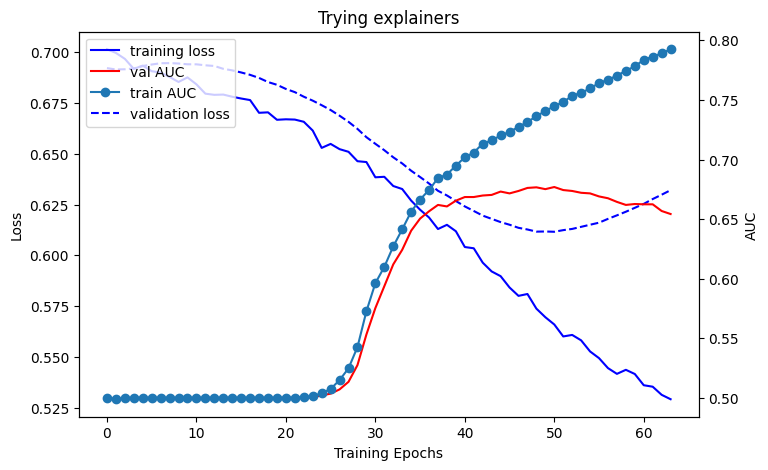

In [132]:
train_params = {
    'weight_decay': 1e-2,
    'lr': 0.001,
    'epochs':100,
    "patience":5,
    "delta":0.01,
}
trained_model, auc = launch_experiment(dblp_model,train_data,val_data,train_params)

In [133]:
full_test(trained_model,val_data,200,False)

{('author', 'to', 'paper'): [0.65, 0.6, 0.65, 176.0]}

In [382]:
with torch.no_grad():
    dblp_model.eval()
    aver = dblp_model(train_data.x_dict,train_data.edge_index_dict,train_data.edge_label_index_dict,return_tensor=True)

## Gene-Disease experiment

In [28]:
train_params = {
    'weight_decay': 0.001,
    'lr': 0.001,
    'epochs':400,
    "patience":5,
    "delta":0.01,
}

model_params = {"hidden_channels":32,
                "conv_type":"SAGEConv",
                "batch_norm":True,
                "dropout":0.1,
                "micro_aggregation":"sum",
                "macro_aggregation":"sum",
                "layer_connectivity":None,
                "L2_norm":True,
                "pre_process_layers":0,
                "msg_passing_layers":2,
                "post_process_layers":1,
                "normalize_output":False,
                "jumping_knowledge":False

}

feature_dim = 10
feature_type = 'ones'


In [29]:
model = base_model(model_params,train_data.metadata(),[('gene_protein', 'gda', 'disease')])

0.6981057524681091
0.3357681632041931
0.2776956856250763
0.2624017596244812
0.25178784132003784
0.24735276401042938
0.24574829638004303
0.2429131418466568


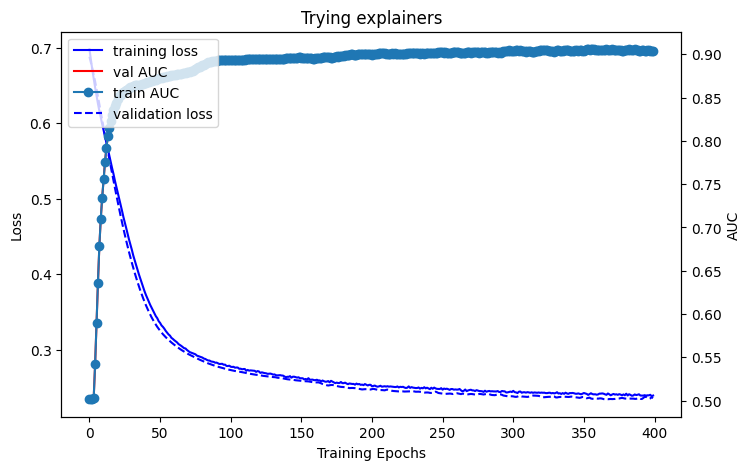

In [30]:
train_params = {
    'weight_decay': 0.001,
    'lr': 0.001,
    'epochs':400,
    "patience":5,
    "delta":0.01,
}
trained_model, auc = launch_experiment(model,train_data,val_data,train_params)

In [33]:
full_test(trained_model,val_data,500,False)

{('gene_protein', 'gda', 'disease'): [0.9, 0.86, 0.9, 496.0]}

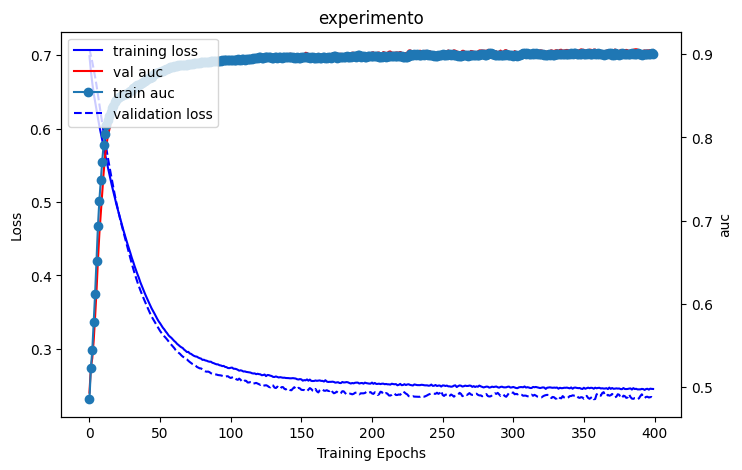

In [27]:
plot_training_stats("experimento",*experiment_params["curve_data"],"auc")

# Explainer ????????????!

In [369]:
explainer = Explainer(
    model=dblp_model,
    algorithm=CaptumExplainer('IntegratedGradients'),
    explanation_type='model',
    model_config=dict(
        mode='binary_classification',
        task_level='edge',
        return_type='probs',
    ),
    node_mask_type='attributes',
    edge_mask_type='object',
)

In [416]:
explanation = explainer(
    train_data.x_dict,
    train_data.edge_index_dict,
    index = torch.tensor([1]),
    edge_label_index=train_data.edge_label_index_dict,
    return_tensor = True
)

TypeError: 'IntegratedGradients' object is not callable

In [408]:
class encoder(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.pre_linear = torch.nn.LazyLinear(32)
        self.pre_act = torch.nn.LeakyReLU()

        self.conv1 = SAGEConv(32,32)
        self.bn1 = torch.nn.BatchNorm1d(32)
        self.dropout1 = torch.nn.Dropout(0.1)
        self.conv1_act = torch.nn.LeakyReLU()

        self.conv2 = SAGEConv(32,32)
        self.bn2 = torch.nn.BatchNorm1d(32)
        self.dropout2 = torch.nn.Dropout(0.1)
        self.conv2_act = torch.nn.LeakyReLU()

        self.post_linear = torch.nn.Linear(32,32)
    
    def forward(self,x:dict,edge_index:dict) -> dict:
        x = self.pre_linear(x)
        x = self.pre_act(x)

        x = self.conv1(x,edge_index)
        x = self.bn1(x)
        x = self.dropout1(x)
        x = self.conv1_act(x)

        x = self.conv2(x,edge_index)
        x = self.bn2(x)
        x = self.dropout2(x)
        x = self.conv2_act(x)

        x = self.post_linear(x)

        return x

class inner_product_decoder(torch.nn.Module):
    def forward(self,x:dict,edge_label_index:dict,supervision_types,apply_sigmoid=True) -> dict:
        pred_dict = {}
        for edge_type in supervision_types:
            edge_index = edge_label_index[edge_type]
            
            x_src = x[edge_type[0]]
            x_trg = x[edge_type[2]]

            nodes_src = x_src[edge_index[0]]
            nodes_trg = x_trg[edge_index[1]]

            pred = (nodes_src * nodes_trg).sum(dim=-1)

            if apply_sigmoid:
                pred = torch.sigmoid(pred)

            pred_dict[edge_type] = pred
        
        return pred_dict

class Model(torch.nn.Module):
    def __init__(self,metadata,supervision_types):
        super().__init__()
          
        self.encoder = to_hetero(encoder(),metadata)
        self.decoder = inner_product_decoder()
        self.loss_fn = torch.nn.BCELoss()
        self.supervision_types = supervision_types
    
    
    def forward(self,x:dict,edge_index:dict,edge_label_index:dict,return_tensor=False) -> dict:
        x = self.encoder(x,edge_index)
        pred = self.decoder(x,edge_label_index,self.supervision_types)

        if return_tensor:
            pred = pred[self.supervision_types[0]]

        return pred
    
    def loss(self, prediction_dict, label_dict):
        loss = 0
        for edge_type,pred in prediction_dict.items():
            y = label_dict[edge_type]
            loss += self.loss_fn(pred, y.type(pred.dtype))
        return loss

In [410]:
supervision_types = [('author', 'to', 'paper')]
model = Model(train_data.metadata(),supervision_types)

/home/ingrid/Documents/tesis/gcnn_gdas/venv/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


1.003982663154602
0.09185915440320969
Early stopping


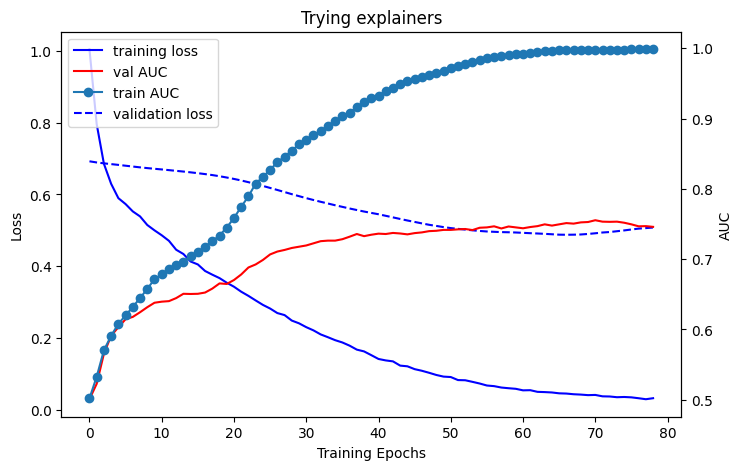

In [411]:
train_params = {
    'weight_decay': 1e-2,
    'lr': 0.001,
    'epochs':100,
    "patience":5,
    "delta":0.01,
}
trained_model, auc = launch_experiment(model,train_data,val_data,train_params)

In [414]:
explainer = Explainer(
    model=dblp_model,
    algorithm=CaptumExplainer('IntegratedGradients'),
    explanation_type='model',
    model_config=dict(
        mode='binary_classification',
        task_level='edge',
        return_type='probs',
    ),
    node_mask_type='attributes',
    edge_mask_type='object',
)


explanation = explainer(
    train_data.x_dict,
    train_data.edge_index_dict,
    index = torch.tensor([1]),
    edge_label_index=train_data.edge_label_index_dict,
    return_tensor = True
)

In [415]:
explanation

HeteroExplanation(
  prediction=[6286],
  target=[6286],
  index=[1],
  return_tensor=True,
  author={
    node_mask=[4057, 334],
    x=[4057, 334]
  },
  paper={
    node_mask=[14328, 4231],
    x=[14328, 4231]
  },
  term={
    node_mask=[7723, 50],
    x=[7723, 50]
  },
  conference={
    node_mask=[20, 20],
    x=[20, 20]
  },
  (author, to, paper)={
    edge_mask=[12574],
    edge_index=[2, 12574],
    edge_label_index=[2, 6286]
  },
  (paper, to, author)={
    edge_mask=[12574],
    edge_index=[2, 12574]
  },
  (paper, to, term)={
    edge_mask=[54919],
    edge_index=[2, 54919],
    edge_label_index=[2, 27458]
  },
  (paper, to, conference)={
    edge_mask=[9172],
    edge_index=[2, 9172],
    edge_label_index=[2, 4584]
  },
  (term, to, paper)={
    edge_mask=[54919],
    edge_index=[2, 54919]
  },
  (conference, to, paper)={
    edge_mask=[9172],
    edge_index=[2, 9172]
  },
  (paper, rev_to, author)={
    edge_mask=[19645],
    edge_index=[2, 19645]
  },
  (author, rev_to, p